In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

In [2]:
import pymysql
from dotenv import load_dotenv
import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
plt.rc('font', family = 'Hancom Gothic')

In [3]:
# 하이퍼파라미터
my_patience = 30
my_epochs = 1000
my_optimizer = Adam(learning_rate=0.00001)
my_batch_size = 100 # 작게 하면 더 미세하게 학습, 크게 하면 빠르고 덜 세밀

# 데이터 체크

In [4]:
load_dotenv()
host = os.getenv('host')
user = os.getenv('user')
password = os.getenv('password')
database = os.getenv('database')
port = int(os.getenv('port', 3306))

query =f"""
    SELECT *
    FROM basic_data"""

try:
    connection = pymysql.connect(
        host=host,
        user=user,
        password=password,
        database=database,
        port=port,
        charset='utf8mb4',
        cursorclass=pymysql.cursors.DictCursor
    )
    with connection.cursor() as cursor:
        cursor.execute(query)
        data = cursor.fetchall()
        whole_data = pd.DataFrame(data)
except Exception as e:
    print('에러 발생:', e)
finally:
    try:
        connection.close()
    except:
        pass

In [5]:
whole_data[whole_data['year']!=2025].isna().sum() # 학습에 사용할 데이터 : 21 ~ 24년 데이터, 결측치 X

year                0
month               0
day                 0
hour                0
district            0
datetime            0
total_population    0
season              0
commute_time        0
weekend_flag        0
precipitation       0
temperature         0
humidity            0
wind_speed          0
rental_count        0
dtype: int64

In [6]:
# PM데이터 로드
df_pm = pd.read_csv('PM_data/서울시_시간별_PM_배치_2021_2025.csv', parse_dates=['일시'])
df_pm.columns =['일시','행정구','PM대여량']

In [7]:
df_pm.isna().sum() # 결측치 0건

일시       0
행정구      0
PM대여량    0
dtype: int64

In [8]:
# 데이터 concat
whole_data.columns = ['연도','월','일','시','행정구','일시','총생활인구수','계절','출퇴근시간여부','주말구분','강수','기온','습도','풍속','공공자전거대여량']

In [9]:
whole_data = whole_data[whole_data['연도']!=2025]
whole_data.shape

(872093, 15)

In [10]:
whole_data.info()
df_pm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 872093 entries, 0 to 872092
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   연도        872093 non-null  int64         
 1   월         872093 non-null  int64         
 2   일         872093 non-null  int64         
 3   시         872093 non-null  int64         
 4   행정구       872093 non-null  object        
 5   일시        872093 non-null  datetime64[ns]
 6   총생활인구수    872093 non-null  int64         
 7   계절        872093 non-null  object        
 8   출퇴근시간여부   872093 non-null  object        
 9   주말구분      872093 non-null  int64         
 10  강수        872093 non-null  float64       
 11  기온        872093 non-null  float64       
 12  습도        872093 non-null  float64       
 13  풍속        872093 non-null  float64       
 14  공공자전거대여량  872093 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(6), object(3)
memory usage: 106.5+ MB
<class 

In [11]:
df_total = whole_data.merge(df_pm, on=['행정구','일시'])
df_total

,연도,월,일,시,행정구,일시,총생활인구수,계절,출퇴근시간여부,주말구분,강수,기온,습도,풍속,공공자전거대여량,PM대여량
0,2021,1,1,0,강남구,2021-01-01 00:00:00,618455,겨울,기타,0,0.0,-4.2,59.0,1.4,9.0,24
1,2021,1,1,0,강동구,2021-01-01 00:00:00,525221,겨울,기타,0,0.0,-6.6,60.0,1.4,12.0,21
2,2021,1,1,0,강북구,2021-01-01 00:00:00,321499,겨울,기타,0,0.0,-5.4,54.0,1.1,12.0,3
3,2021,1,1,0,강서구,2021-01-01 00:00:00,547288,겨울,기타,0,0.0,-3.3,52.0,0.9,27.0,3
4,2021,1,1,0,관악구,2021-01-01 00:00:00,492742,겨울,기타,0,0.0,-2.5,50.0,0.9,19.0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662781,2024,12,31,23,송파구,2024-12-31 23:00:00,718964,겨울,기타,0,0.0,0.5,61.0,1.3,115.0,37
662782,2024,12,31,23,양천구,2024-12-31 23:00:00,378141,겨울,기타,0,0.0,1.7,63.0,1.8,101.0,16
662783,2024,12,31,23,영등포구,2024-12-31 23:00:00,420498,겨울,기타,0,0.0,1.3,62.0,1.2,113.0,6
662784,2024,12,31,23,은평구,2024-12-31 23:00:00,453206,겨울,기타,0,0.0,0.3,62.0,1.3,35.0,5


In [12]:
df_total[df_total.isna().any(axis=1)]

,연도,월,일,시,행정구,일시,총생활인구수,계절,출퇴근시간여부,주말구분,강수,기온,습도,풍속,공공자전거대여량,PM대여량


In [13]:
# feature 추출
# 시계열 요소
import holidays
kr_holidays = holidays.KR(years=[2021, 2024])
df_total['공휴일'] = df_total['일시'].dt.date.isin(kr_holidays).astype(int)
# df_total
cols_time = ['연도','월','일','시','계절','출퇴근시간여부','주말구분','공휴일']

# 라벨인코더

In [14]:
# 라벨 인코딩
from sklearn.preprocessing import LabelEncoder
le_season = LabelEncoder()
le_commute = LabelEncoder()
le_gu = LabelEncoder()
df_total['계절'] = le_season.fit_transform(df_total['계절'].values)
df_total['출퇴근시간여부'] = le_commute.fit_transform(df_total['출퇴근시간여부'].values)
df_total['행정구'] = le_gu.fit_transform(df_total['행정구'].values)
df_total

,연도,월,일,시,행정구,일시,총생활인구수,계절,출퇴근시간여부,주말구분,강수,기온,습도,풍속,공공자전거대여량,PM대여량,공휴일
0,2021,1,1,0,0,2021-01-01 00:00:00,618455,1,0,0,0.0,-4.2,59.0,1.4,9.0,24,1
1,2021,1,1,0,1,2021-01-01 00:00:00,525221,1,0,0,0.0,-6.6,60.0,1.4,12.0,21,1
2,2021,1,1,0,2,2021-01-01 00:00:00,321499,1,0,0,0.0,-5.4,54.0,1.1,12.0,3,1
3,2021,1,1,0,3,2021-01-01 00:00:00,547288,1,0,0,0.0,-3.3,52.0,0.9,27.0,3,1
4,2021,1,1,0,4,2021-01-01 00:00:00,492742,1,0,0,0.0,-2.5,50.0,0.9,19.0,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662781,2024,12,31,23,14,2024-12-31 23:00:00,718964,1,0,0,0.0,0.5,61.0,1.3,115.0,37,0
662782,2024,12,31,23,15,2024-12-31 23:00:00,378141,1,0,0,0.0,1.7,63.0,1.8,101.0,16,0
662783,2024,12,31,23,16,2024-12-31 23:00:00,420498,1,0,0,0.0,1.3,62.0,1.2,113.0,6,0
662784,2024,12,31,23,17,2024-12-31 23:00:00,453206,1,0,0,0.0,0.3,62.0,1.3,35.0,5,0


# PM운영 행정구와 전체 행정구 체크
- PM의 경우 서울시에 운영현황을 공유한 회사만 체크

In [15]:
df_total['행정구'].unique()
pm_gu_list = le_gu.classes_.tolist()

In [16]:
gu_list = whole_data['행정구'].unique().tolist()

# 스케일 조정
- 시계열 내용 time_cols = ['연도','월','일','시','계절','출퇴근시간여부','주말구분','공휴일'] 를 제외 나머지 연속형 데이터 스케일 조정

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cols_scale = ['총생활인구수', '강수', '기온','습도','풍속','공공자전거대여량'] # 독립변수만
df_total[cols_scale] = scaler.fit_transform(df_total[cols_scale].values)
df_total

,연도,월,일,시,행정구,일시,총생활인구수,계절,출퇴근시간여부,주말구분,강수,기온,습도,풍속,공공자전거대여량,PM대여량,공휴일
0,2021,1,1,0,0,2021-01-01 00:00:00,0.431544,1,0,0,0.011628,0.519864,0.594059,0.210526,0.002456,24,1
1,2021,1,1,0,1,2021-01-01 00:00:00,0.342346,1,0,0,0.011628,0.492622,0.603960,0.210526,0.003377,21,1
2,2021,1,1,0,2,2021-01-01 00:00:00,0.147441,1,0,0,0.011628,0.506243,0.544554,0.184211,0.003377,3,1
3,2021,1,1,0,3,2021-01-01 00:00:00,0.363457,1,0,0,0.011628,0.530079,0.524752,0.166667,0.007983,3,1
4,2021,1,1,0,4,2021-01-01 00:00:00,0.311272,1,0,0,0.011628,0.539160,0.504950,0.166667,0.005527,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662781,2024,12,31,23,14,2024-12-31 23:00:00,0.527703,1,0,0,0.011628,0.573212,0.613861,0.201754,0.035002,37,0
662782,2024,12,31,23,15,2024-12-31 23:00:00,0.201632,1,0,0,0.011628,0.586833,0.633663,0.245614,0.030703,16,0
662783,2024,12,31,23,16,2024-12-31 23:00:00,0.242155,1,0,0,0.011628,0.582293,0.623762,0.192982,0.034387,6,0
662784,2024,12,31,23,17,2024-12-31 23:00:00,0.273448,1,0,0,0.011628,0.570942,0.623762,0.201754,0.010439,5,0


In [18]:
# 1. 1년 전 '연도', '월', '일', '시' 컬럼 생성
df_total['1년전_연도'] = df_total['연도'] - 1

# 2. merge용 key 생성
merge_cols = ['행정구', '1년전_연도', '월', '일', '시']
df_total['merge_key'] = df_total['행정구'].astype(str) + '_' + (df_total['연도']-1).astype(str) + '_' + df_total['월'].astype(str) + '_' + df_total['일'].astype(str) + '_' + df_total['시'].astype(str)

df_total['now_key'] = df_total['행정구'].astype(str) + '_' + df_total['연도'].astype(str) + '_' + df_total['월'].astype(str) + '_' + df_total['일'].astype(str) + '_' + df_total['시'].astype(str)

df_yearago = df_total[['now_key', '총생활인구수', 'PM대여량']].copy()
df_yearago.columns = ['merge_key', '1년전_총생활인구수', '1년전_PM대여량']

df_total = df_total.merge(df_yearago, on='merge_key', how='left')
df_total = df_total.dropna().drop(['merge_key', 'now_key','1년전_연도'],axis=1)

# 타겟변수 범주화

## 범주 기준 clustering

In [19]:
print('타겟변수 최대값 :',df_total['PM대여량'].max())
print('타겟변수 최소값 :',df_total['PM대여량'].min())
print('타겟변수 평균 :',df_total['PM대여량'].mean())
print('타겟변수 표준편차 :',df_total['PM대여량'].std())
display(df_total['PM대여량'].describe())

타겟변수 최대값 : 167
타겟변수 최소값 : 3
타겟변수 평균 : 28.435073610833772
타겟변수 표준편차 : 24.659611717346884


count    550870.000000
mean         28.435074
std          24.659612
min           3.000000
25%           9.000000
50%          22.000000
75%          39.000000
max         167.000000
Name: PM대여량, dtype: float64

### cluster용 샘플 데이터 1.
- 50개 단위로 끊어서 시계열 유지

In [20]:
sample_data = df_total[::50]
sample_data.shape

(11018, 19)

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for n_clusters in range(2,10) :
    cluster = KMeans(n_clusters=n_clusters,
                  n_init = 10,)
    cluster.fit(sample_data[['연도','월','일','시','행정구','총생활인구수','계절','출퇴근시간여부','주말구분','강수','기온','습도','풍속','공공자전거대여량','공휴일','1년전_총생활인구수','1년전_PM대여량']].values)
    pred = cluster.labels_
    score = silhouette_score(X = sample_data[['연도','월','일','시','행정구','총생활인구수','계절','출퇴근시간여부','주말구분','강수','기온','습도','풍속','공공자전거대여량','공휴일','1년전_총생활인구수','1년전_PM대여량']],
                            labels = pred)
    print(f"클러스트수 : {n_clusters}, 실루엣 계수 : {score}")

클러스트수 : 2, 실루엣 계수 : 0.5034152029287449
클러스트수 : 3, 실루엣 계수 : 0.35829080766409677
클러스트수 : 4, 실루엣 계수 : 0.2928090306335364
클러스트수 : 5, 실루엣 계수 : 0.25021259315453737
클러스트수 : 6, 실루엣 계수 : 0.24037891458352895
클러스트수 : 7, 실루엣 계수 : 0.23465306470953057
클러스트수 : 8, 실루엣 계수 : 0.2252786575537092
클러스트수 : 9, 실루엣 계수 : 0.21832308531956343


### cluster용 샘플 데이터 2.
- 1개월 단위로 샘플링
- 연단위의 경우 데이터의 과다(18만개)로 메모리 이슈 발생

In [23]:
del sample_data

In [24]:
sample_data = df_total[df_total['월']==7]
sample_data.shape

(47221, 19)

In [25]:
for n_clusters in range(2,10) :
    cluster = KMeans(n_clusters=n_clusters,
                  n_init = 10,)
    cluster.fit(sample_data[['연도','월','일','시','행정구','총생활인구수','계절','출퇴근시간여부','주말구분','강수','기온','습도','풍속','공공자전거대여량','공휴일','1년전_총생활인구수','1년전_PM대여량']].values)
    pred = cluster.labels_
    score = silhouette_score(X = sample_data[['연도','월','일','시','행정구','총생활인구수','계절','출퇴근시간여부','주말구분','강수','기온','습도','풍속','공공자전거대여량','공휴일','1년전_총생활인구수','1년전_PM대여량']],
                            labels = pred)
    print(f"클러스트수 : {n_clusters}, 실루엣 계수 : {score}")

클러스트수 : 2, 실루엣 계수 : 0.50380245956795
클러스트수 : 3, 실루엣 계수 : 0.3571750579350531
클러스트수 : 4, 실루엣 계수 : 0.31127190214918143
클러스트수 : 5, 실루엣 계수 : 0.2703939030900694
클러스트수 : 6, 실루엣 계수 : 0.27035878459618323
클러스트수 : 7, 실루엣 계수 : 0.26017600961164794
클러스트수 : 8, 실루엣 계수 : 0.25187154305100445
클러스트수 : 9, 실루엣 계수 : 0.244388411222825


### cluster용 샘플 데이터 3.
- 1년 단위로 샘플링
- feature 축소를 통해 메모리 부족 해소

In [26]:
del sample_data

In [27]:
sample_data = df_total[df_total['월']==7]
sample_data.shape

(47221, 19)

In [28]:
for n_clusters in range(2,10) :
    cluster = KMeans(n_clusters=n_clusters,
                  n_init = 10,)
    input_data = sample_data[['연도','월','일','시','행정구','총생활인구수','강수','기온','습도','풍속','공공자전거대여량','1년전_총생활인구수','1년전_PM대여량']].values
    cluster.fit(input_data)
    pred = cluster.labels_
    score = silhouette_score(X = input_data,
                            labels = pred)
    print(f"클러스트수 : {n_clusters}, 실루엣 계수 : {score}")

클러스트수 : 2, 실루엣 계수 : 0.5020230718545858
클러스트수 : 3, 실루엣 계수 : 0.3587312000312493
클러스트수 : 4, 실루엣 계수 : 0.3121305262017013
클러스트수 : 5, 실루엣 계수 : 0.2713132441876673
클러스트수 : 6, 실루엣 계수 : 0.2714484744987242
클러스트수 : 7, 실루엣 계수 : 0.2613360692833384
클러스트수 : 8, 실루엣 계수 : 0.2532321690074345
클러스트수 : 9, 실루엣 계수 : 0.2457243502992503


# 실루엣 계수 분석
```
count    550870.000000
mean         28.435074
std          24.659612
min           3.000000
25%           9.000000
50%          22.000000
75%          39.000000
max         167.000000
```
- cluster가 2~3 개일 때 실루엣계수가 가장 높으나
- 실질적으로 PM을 재배치하기에 구간을 분배하기 위한 조건으로는 부족함.
- 평균이 28이고 Q3가 39인 것을 고려하여 수동 bin 배분이 필요하다고 사료됨.
- 범주는 4분위 수와 편차를 기준으로 아래와 같이 구분하여 학습
    * 0~9 공급과다 
    * 9~39 공급평균 
    * 39 ~ 65 공급다소부족
    * 65 ~ 90 공급부족
    * 90 + 공급절대 부족 5개 구간으로 분리

공급평균      282760
공급과다      126135
공급다소부족     87145
공급부족       38002
공급절대부족     16828
Name: PM대여량_class, dtype: int64


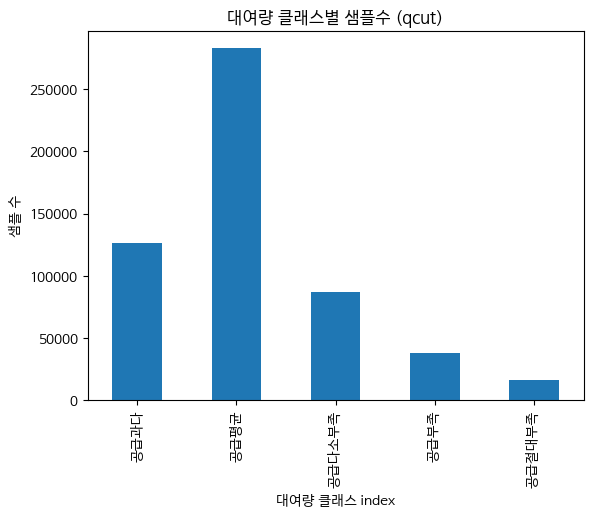

In [29]:
import numpy as np
import pandas as pd
# 타겟변수 범주화
bins = [0, 9, 39, 65, 90, np.inf]
num_bins = len(bins)
labels = ['공급과다', '공급평균', '공급다소부족', '공급부족', '공급절대부족']

# 'PM대여량'을 구간화해서 범주 label로 변환
df_total['PM대여량_class'] = pd.cut(
    df_total['PM대여량'],
    bins=bins,
    labels=labels,
    right=False  # 9, 39, 65, 90은 각 구간의 시작값 포함, 끝값은 미포함
)

# 결과 확인
print(df_total['PM대여량_class'].value_counts())

df_total['PM대여량_class'].value_counts(sort=False).plot(kind='bar')
plt.title('대여량 클래스별 샘플수 (qcut)')
plt.xlabel('대여량 클래스 index')
plt.ylabel('샘플 수')
plt.show()

## 데이터의 불균형이 발생하였으나 절대적인 data의 수가 부족하진 않다고 생각하여 학습 진행

In [30]:
df_total

,연도,월,일,시,행정구,일시,총생활인구수,계절,출퇴근시간여부,주말구분,강수,기온,습도,풍속,공공자전거대여량,PM대여량,공휴일,1년전_총생활인구수,1년전_PM대여량,PM대여량_class
165265,2022,1,1,0,0,2022-01-01 00:00:00,0.434509,1,0,1,0.011628,0.527809,0.366337,0.210526,0.001228,33,0,0.431544,24.0,공급평균
165266,2022,1,1,0,1,2022-01-01 00:00:00,0.342358,1,0,1,0.011628,0.493757,0.405941,0.192982,0.007062,25,0,0.342346,21.0,공급평균
165267,2022,1,1,0,2,2022-01-01 00:00:00,0.136425,1,0,1,0.011628,0.496027,0.396040,0.157895,0.002763,5,0,0.147441,3.0,공급과다
165268,2022,1,1,0,3,2022-01-01 00:00:00,0.355300,1,0,1,0.011628,0.517594,0.336634,0.219298,0.017808,4,0,0.363457,3.0,공급과다
165269,2022,1,1,0,4,2022-01-01 00:00:00,0.292608,1,0,1,0.011628,0.499432,0.326733,0.245614,0.007676,20,0,0.311272,18.0,공급평균
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718226,2024,12,31,23,16,2024-12-31 23:00:00,0.242155,1,0,0,0.011628,0.582293,0.623762,0.192982,0.034387,6,0,0.229339,7.0,공급과다
718227,2024,12,31,23,17,2024-12-31 23:00:00,0.273448,1,0,0,0.011628,0.570942,0.623762,0.201754,0.010439,5,0,0.270446,7.0,공급과다
718228,2024,12,31,23,17,2024-12-31 23:00:00,0.273448,1,0,0,0.011628,0.570942,0.623762,0.201754,0.010439,5,0,0.270446,65.0,공급과다
718229,2024,12,31,23,17,2024-12-31 23:00:00,0.273448,1,0,0,0.011628,0.570942,0.623762,0.201754,0.010439,52,0,0.270446,7.0,공급다소부족


# 타겟변수 라벨인코딩

In [32]:
from sklearn.preprocessing import LabelEncoder
le_target = LabelEncoder()
df_total['PM대여량_class'] = le_target.fit_transform(df_total['PM대여량_class'].values)
df_total['PM대여량_class']

165265    4
165266    4
165267    0
165268    0
165269    4
         ..
718226    0
718227    0
718228    0
718229    1
718230    1
Name: PM대여량_class, Length: 550870, dtype: int32

# feature 선정 

## 상관계수 체크

In [33]:
import pandas as pd
corrs = df_total.corr(numeric_only=True)
corrs['PM대여량'].sort_values(ascending=False)  # 타겟과의 상관계수

PM대여량          1.000000
1년전_PM대여량      0.579309
1년전_총생활인구수     0.326858
총생활인구수         0.322036
출퇴근시간여부        0.169530
시              0.153159
주말구분           0.145724
공공자전거대여량       0.093070
습도             0.086837
기온             0.083839
행정구            0.067721
월              0.044868
PM대여량_class    0.039231
계절             0.008641
강수             0.003174
일              0.001796
공휴일           -0.001834
연도            -0.002853
풍속            -0.108760
Name: PM대여량, dtype: float64

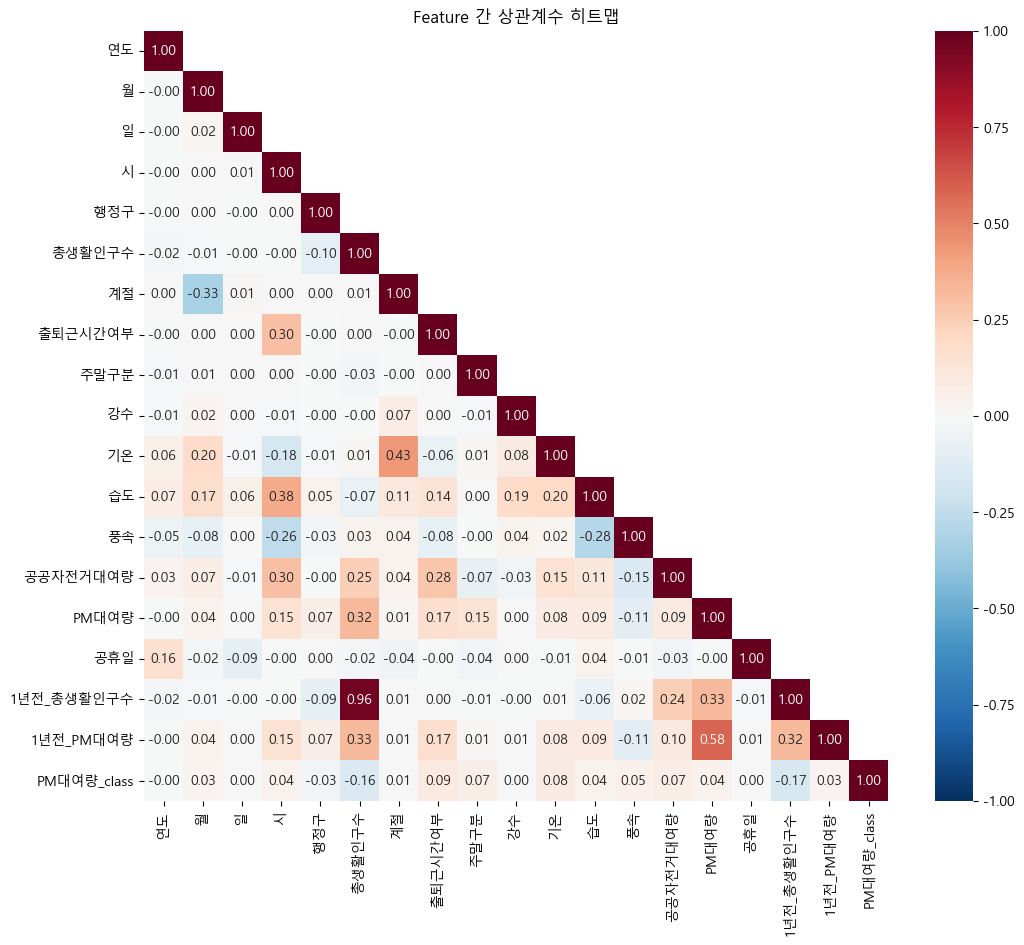

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font',family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

mask = np.triu(np.ones_like(corrs, dtype=bool), k=1)
plt.figure(figsize=(12,10))
sns.heatmap(corrs, annot=True,mask=mask, fmt='.2f', cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Feature 간 상관계수 히트맵')
plt.show()

## 결과에 따라 상관계수가 0에 가까운 순으로 제외 예정 
- 목표 accuracy = 0.75 이상, f1-score, recall/precision 0.7 이상

In [35]:
corrs['PM대여량'].sort_values(ascending=False).index # 결과에 따라 상관계수가 0에 가까운 순으로 제외 예정
sorted_idx = np.abs(corrs)['PM대여량'].sort_values(ascending=False).index
sorted_idx

Index(['PM대여량', '1년전_PM대여량', '1년전_총생활인구수', '총생활인구수', '출퇴근시간여부', '시', '주말구분',
       '풍속', '공공자전거대여량', '습도', '기온', '행정구', '월', 'PM대여량_class', '계절', '강수',
       '연도', '공휴일', '일'],
      dtype='object')

## 데이터 독립변수, 종속변수 분리

In [36]:
# 독립변수, 종속변수 분리용
# 1차 시도 ['연도','월','일','시','행정구','총생활인구수','계절','출퇴근시간여부','주말구분','강수','기온','습도','풍속','공공자전거대여량','공휴일','1년전_총생활인구수','1년전_PM대여량']
# 2차 시도 ['연도','월','일','시','행정구','총생활인구수','강수','기온','습도','풍속','공공자전거대여량','공휴일','1년전_총생활인구수','1년전_PM대여량']
cols_X = ['연도','월','일','시','행정구','총생활인구수','계절','출퇴근시간여부','주말구분','강수','기온','습도','풍속','공공자전거대여량','공휴일','1년전_총생활인구수','1년전_PM대여량']
cols_y = ['PM대여량_class']
# train_set, val_set, test_set
train_set = df_total[df_total['연도']==2022]
val_set = df_total[df_total['연도']==2023]
test_set = df_total[df_total['연도']==2024]

train_X = train_set[cols_X].values
val_X = val_set[cols_X].values
test_X = test_set[cols_X].values

train_y = train_set[cols_y].values
val_y = val_set[cols_y].values
test_y = test_set[cols_y].values

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape

((182980, 17),
 (182980, 1),
 (183602, 17),
 (183602, 1),
 (184288, 17),
 (184288, 1))

# 모델 설계

In [37]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model

In [38]:
Inp = Input((train_X.shape[1],))
x = Dense(512, activation = 'relu')(Inp)
x = Dense(2048, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
Out = Dense(num_bins, activation = 'softmax')(x)

model = Model(inputs = Inp, outputs= Out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense (Dense)               (None, 512)               9216      
                                                                 
 dense_1 (Dense)             (None, 2048)              1050624   
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
Total params: 1,601,222
Trainable params: 1,601,222
Non-train

# 모델 학습과정

In [39]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=my_optimizer, metrics=['accuracy'])

# 모델 학습

In [40]:
es = EarlyStopping(patience=my_patience)
mc = ModelCheckpoint('Backups/loss{val_loss}_accuracy{val_accuracy}.h5')

history = model.fit(train_X,train_y,
    epochs=my_epochs,
    verbose='auto',
    callbacks=[es,mc],
    shuffle=False, # 시계열 요소 고려 shuffle = False
    batch_size=my_batch_size,
    validation_data=(val_X,val_y))

Epoch 1/1000
1830/1830 [==============================] - 7s 3ms/step - loss: 1.6033 - accuracy: 0.4964 - val_loss: 1.4894 - val_accuracy: 0.3830
Epoch 2/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 1.2470 - accuracy: 0.5476 - val_loss: 1.2796 - val_accuracy: 0.5007
Epoch 3/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 1.1779 - accuracy: 0.5810 - val_loss: 1.1701 - val_accuracy: 0.5880
Epoch 4/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 1.1168 - accuracy: 0.6019 - val_loss: 1.1130 - val_accuracy: 0.6222
Epoch 5/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 1.0727 - accuracy: 0.6212 - val_loss: 1.0713 - val_accuracy: 0.6456
Epoch 6/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 1.0463 - accuracy: 0.6355 - val_loss: 1.0232 - val_accuracy: 0.6597
Epoch 7/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 1.0400 - accuracy: 0.6444 - val_loss: 1.0447 -

Epoch 57/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 0.7325 - accuracy: 0.7278 - val_loss: 0.6366 - val_accuracy: 0.7731
Epoch 58/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 0.7276 - accuracy: 0.7270 - val_loss: 0.6370 - val_accuracy: 0.7696
Epoch 59/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 0.7179 - accuracy: 0.7285 - val_loss: 0.6445 - val_accuracy: 0.7708
Epoch 60/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 0.7124 - accuracy: 0.7290 - val_loss: 0.6456 - val_accuracy: 0.7706
Epoch 61/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 0.7046 - accuracy: 0.7313 - val_loss: 0.6530 - val_accuracy: 0.7708
Epoch 62/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 0.7020 - accuracy: 0.7301 - val_loss: 0.6406 - val_accuracy: 0.7713
Epoch 63/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 0.6926 - accuracy: 0.7315 - val_loss: 0

1830/1830 [==============================] - 6s 3ms/step - loss: 0.4851 - accuracy: 0.7791 - val_loss: 0.5530 - val_accuracy: 0.7585
Epoch 168/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 0.4840 - accuracy: 0.7794 - val_loss: 0.5559 - val_accuracy: 0.7575
Epoch 169/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 0.4830 - accuracy: 0.7802 - val_loss: 0.5543 - val_accuracy: 0.7588
Epoch 170/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 0.4824 - accuracy: 0.7800 - val_loss: 0.5466 - val_accuracy: 0.7610
Epoch 171/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 0.4814 - accuracy: 0.7808 - val_loss: 0.5468 - val_accuracy: 0.7603
Epoch 172/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 0.4804 - accuracy: 0.7814 - val_loss: 0.5488 - val_accuracy: 0.7593
Epoch 173/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 0.4797 - accuracy: 0.7814 - val_loss: 0.5439 - 

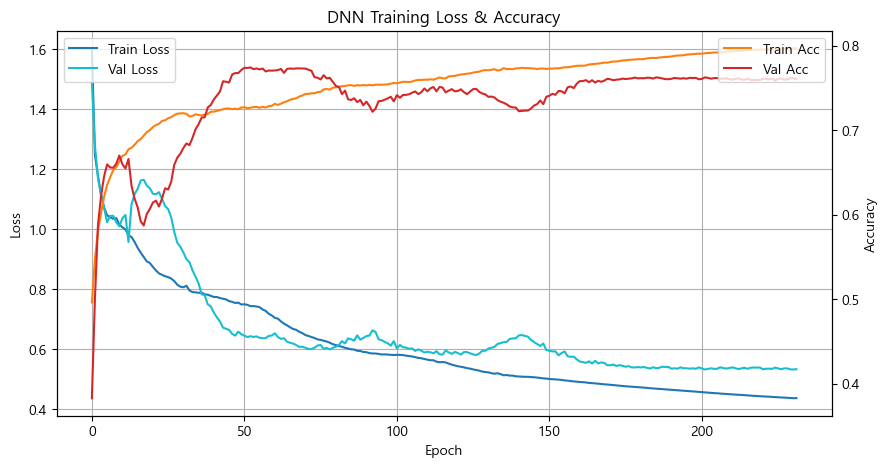

In [48]:
# 학습과정 그래프를 subplots와 twinx로 시각화
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(history.history['loss'], label='Train Loss', color='tab:blue')
ax1.plot(history.history['val_loss'], label='Val Loss', color='tab:cyan')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')
ax1.grid(True)
ax2 = ax1.twinx()
ax2.plot(history.history['accuracy'], label='Train Acc', color='tab:orange')
ax2.plot(history.history['val_accuracy'], label='Val Acc', color='tab:red')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper right')
plt.title('DNN Training Loss & Accuracy')
plt.show()

# 모델의 평가

In [49]:
loss_and_acc = model.evaluate(test_X,test_y)

5759/5759 [==============================] - 10s 2ms/step - loss: 0.5841 - accuracy: 0.7429


In [50]:
test_y
y_hat = model.predict(test_X).argmax(axis=1)

5759/5759 [==============================] - 5s 795us/step


In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('loss :',round(loss_and_acc[0],3))
print('accuracy :',round(loss_and_acc[1],2), '%')
print('precision :',round(precision_score(test_y,y_hat,average='weighted'),2), '%')
print('recall :',round(recall_score(test_y,y_hat,average='weighted'),2), '%')
print('f1_score :',round(f1_score(test_y,y_hat,average='weighted'),2), '%')

loss : 0.584
accuracy : 0.74 %
precision : 0.74 %
recall : 0.74 %
f1_score : 0.73 %


예측값,0,1,2,3,4
실제값,,,,,
0,36923,2713,1288,1,1504
1,3473,18993,654,0,5962
2,3293,4480,3896,89,815
3,716,281,1946,468,2250
4,10211,5117,2089,491,76635


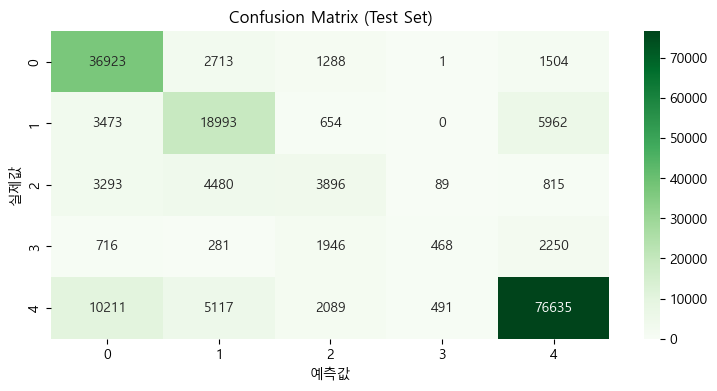

In [53]:
import seaborn as sns
crosstab_y = test_y.reshape(-1)
cm_test = pd.crosstab(crosstab_y, y_hat,rownames=['실제값'],colnames=['예측값'])
display(cm_test)
plt.figure(figsize=(9,4))
sns.heatmap(cm_test.values, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('예측값')
plt.ylabel('실제값')
plt.show()

## 모델평가 : 원하는 accuracy와 recall, precision, f1_score
- 그러나 가장 중요한 실제값 4(공급 절대 부족)의 경우 0(공급 과다)로 분류하는 경우 경향성

In [60]:
real_4_predict_value = cm_test.iloc[4,:]
print("공급절대부족_recall :",round(real_4_predict_value.iloc[4] / real_4_predict_value.sum(), 3)*100, "%")
print("공급절대부족 판별이 필요한데 공급과다로 분류 :",round(real_4_predict_value.iloc[0] / real_4_predict_value.sum(), 3)*100, "%")

공급절대부족_recall : 81.10000000000001 %
공급절대부족 판별이 필요한데 공급과다로 분류 : 10.8 %


## 공급절대부족 판별이 필요한데 공급과다로 분류 : 10.8% 발생
* 위 수치를 낮추기 위해
    1. 다른 모델 활용
    2. 모델 depth를 더 깊게 
    3. feature 수정

# 모델 저장

In [61]:
# 모델, 스케일러, 인코더, feature 리스트 저장
# pm_gu_list : PM운영 행정구
# gu_list : 서울시 전체 행정구
# le_season : 계절 라벨인코더
# le_commute : 출퇴근시간여부 라벨 인코더
# le_gu : 행정구 인코더
# scaler : 독립변수 스케일러 / cols_scale = ['총생활인구수', '강수', '기온','습도','풍속','공공자전거대여량']
# le_target : 타겟변수 라벨인코더
import joblib
model.save('M2_categorical_DNN.h5')
joblib.dump(pm_gu_list,'M2_ENCODER\PM활용행정구리스트.pkl')
joblib.dump(gu_list, 'M2_ENCODER\서울전역행정구리스트.pkl')
joblib.dump(le_season, 'M2_ENCODER\계절라벨인코더.pkl')
joblib.dump(le_commute, 'M2_ENCODER\출퇴근시간여부라벨인코더.pkl')
joblib.dump(le_gu, 'M2_ENCODER\행정구라벨인코더.pkl')
joblib.dump(cols_scale, 'M2_ENCODER\독립변수리스트.pkl')
joblib.dump(scaler, 'M2_ENCODER\독립변수스케일러.pkl')

['M2_ENCODER\\독립변수스케일러.pkl']

# 향후 모델 사용 시 활용 함수

In [64]:
def class_to_range(pred_class):
    ''' 모델 예측 결과를 범주형 결과로 반환하는 함수 '''
    labels = ['공급과다', '공급평균', '공급다소부족', '공급부족', '공급절대부족']
    pred_class = int(pred_class)
    return labels[pred_class]